In [9]:
import sys
sys.path.insert(0,'..')

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import torch
import re
from transformers import AutoModel

from src.model_functions import model_factory

from analysis_utils import get_sparsity_for_model, get_sparsity_info, get_viz_data, get_nonzero_dicts

from IPython.display import clear_output

In [11]:
m = AutoModel.from_pretrained("google/bert_uncased_L-4_H-256_A-4")
d = {k:v.numel() for k,v in m.named_parameters()}

d_mod = {}
for k,v in d.items():
    if "pooler" in k:
        continue
    elif "embeddings" in k:
        k_ = ".".join(k.split(".")[1:-1])
        d_mod[k_] = v
    else:
        k_ = ".".join(k.split(".")[3:-1])
        try:
            d_mod[k_] += v
        except KeyError:
            d_mod[k_] = v

d_mod = dict(sorted(d_mod.items(), key=lambda item: item[1], reverse=True))
for k,v in d_mod.items():
    k_ = k.replace("_", "\\_")
    s = f"{k_} & \\num[group-separator={{,}}]{{{v}}} \\\\"
    print(s)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


word\_embeddings & \num[group-separator={,}]{7813632} \\
intermediate.dense & \num[group-separator={,}]{1052672} \\
output.dense & \num[group-separator={,}]{1049600} \\
attention.self.query & \num[group-separator={,}]{263168} \\
attention.self.key & \num[group-separator={,}]{263168} \\
attention.self.value & \num[group-separator={,}]{263168} \\
attention.output.dense & \num[group-separator={,}]{263168} \\
position\_embeddings & \num[group-separator={,}]{131072} \\
attention.output.LayerNorm & \num[group-separator={,}]{2048} \\
output.LayerNorm & \num[group-separator={,}]{2048} \\
token\_type\_embeddings & \num[group-separator={,}]{512} \\
LayerNorm & \num[group-separator={,}]{256} \\


In [12]:
output_folder = "charts"
model_type = "bertbase" # bertl4
folder = f"/share/home/lukash/pan16/{model_type}/cp_cp_init"
prot_attr = "age"
par_idx = 0
display_mean_only = True
display_zero_mean = True
savefigs = True

f =  folder.split("/")[-1]
if "modular" in f:
    experiment_name = "modular-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-gender_age-seed{}.pt"
elif "cp_init" in f:
    experiment_name = f"adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-cp_init-weighted_loss_prot-{prot_attr}-seed{'{}'}.pt"
else:
    experiment_name = f"adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-{prot_attr}-seed{'{}'}.pt"

# visualization params
if "modular" in f:
    model_cat = "Modular"
elif "cp_init" in f:
    model_cat = "ModularPostHoc"
else:
    model_cat = "DiffPruning"

In [13]:
model_dicts, model_layer_dicts, model_module_dicts, overall = get_sparsity_info(folder, experiment_name, par_idx=par_idx)
clear_output()

In [14]:
base_dict, layer_dict, module_dict, emb_dict, layer_list = get_viz_data(model_dicts, model_layer_dicts, model_module_dicts)

In [15]:
overall = np.array(overall)
overall_sparsity = (overall.mean(), overall.std())

In [16]:
n_layers = len(layer_list)
n_modules = len(layer_list[0])
module_names = list(layer_list[0].keys())

emb_dict = {k[11:]:v for k,v in base_dict.items() if k[:10]=="embeddings"}
emb_n_modules = len(emb_dict)

cmap = plt.get_cmap('Oranges')

# use to change number range for color gradient
color_fn = lambda x: x # abs(x-1)-0.2

height = 1
width = 2
spacing = 0.5

y_coords = height * np.arange(n_layers) + height/2
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + height, y_coords[-1] + height + spacing]]
)

x_coords = width * np.arange(n_modules) + width/2
x_coords_adj = np.concatenate([
    x_coords,
    [x_coords[-1] + width, x_coords[-1] + width + spacing]
])

hline_positions = np.concatenate([
    (y_coords - height/2),
    [y_coords[-1] + height/2, y_coords_adj[-1] - height/2, y_coords_adj[-1] + height/2]
])
vline_positions = [x_coords[0] - width/2, x_coords[-1] + width/2, x_coords_adj[-1] - width/2, x_coords_adj[-1] + width/2]

ar_to_scalar = lambda ar: ar.flatten()[0]

if display_mean_only:
    text_format = "{:.2%}"
    text_fn = lambda x: [x[0]]
else:
    text_format = "{:.2%}$\pm${:.2%}"
    text_fn = lambda x: x

if display_zero_mean:
    check_zero_fn = lambda a, e: True
else:
    check_zero_fn = lambda a, e: ( (round(a,4)>0) or (round(e,4)>0) )

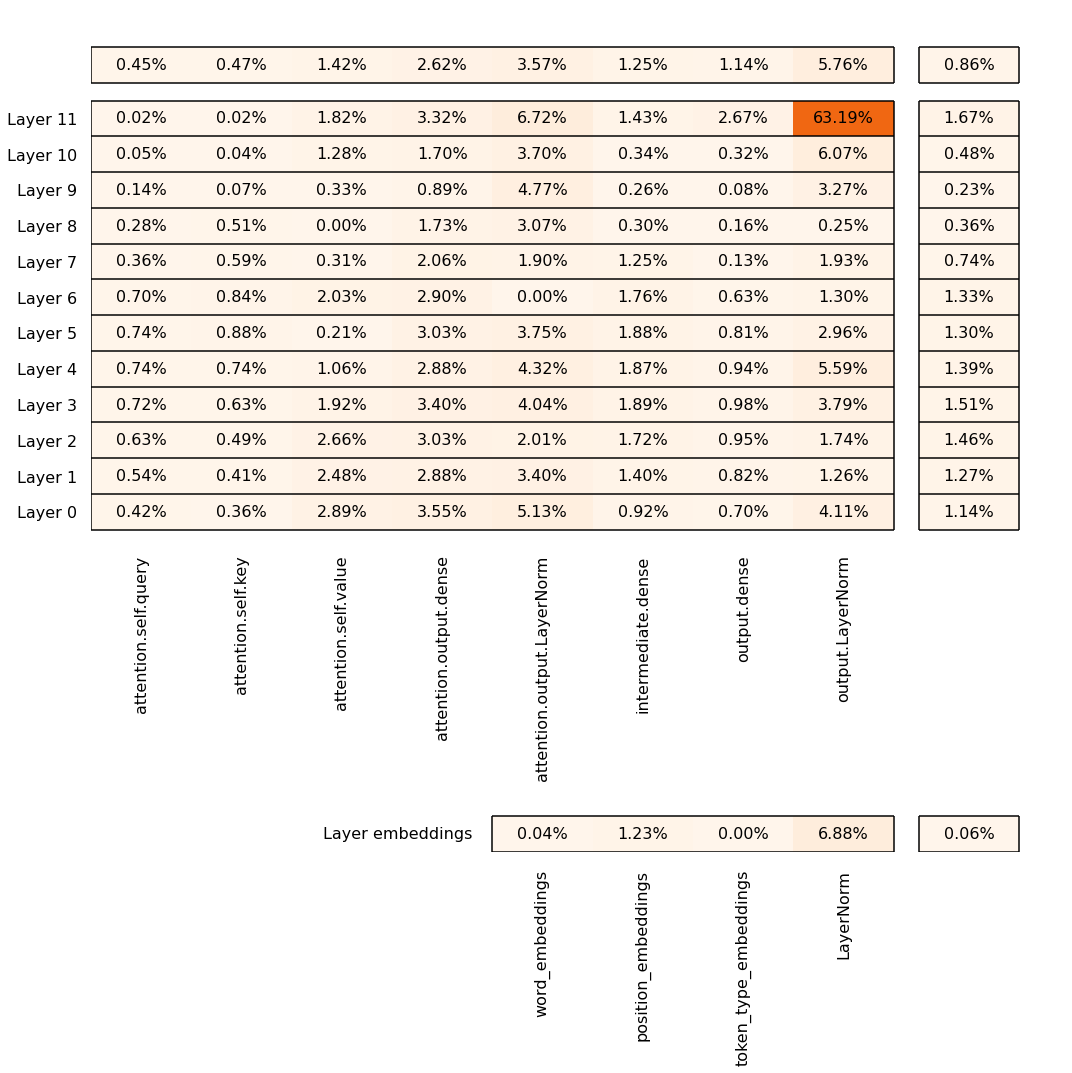

In [17]:
title_fontsize = 16
text_fontsize = 16
title = f"Density per module - {model_cat} - {prot_attr}"
filename = f"density_per_module_{model_cat.lower()}_{prot_attr}.png"

plt.figure(figsize=(15,15))
start = 0
for m_name in module_names:
    averages, error_margins = zip(*[l[m_name] for l in layer_list])
    m_average, m_error_margin = [ar_to_scalar(ar) for ar in module_dict[m_name]]
    color = [cmap(color_fn(a)) for a in averages]
    color.append("w")
    color.append(cmap(color_fn(m_average)))
    plt.barh(y_coords_adj, width, height=height, left=start, color=color)
    for y, a, e in zip(y_coords, averages, error_margins):
        a, e = ar_to_scalar(a), ar_to_scalar(e)
        if check_zero_fn(a,e):
            t = text_format.format(*text_fn(np.array([a, e])))
            plt.text(start+width/2, y, t, ha='center', va='center', color="k", fontsize=text_fontsize)
    if check_zero_fn(m_average, m_error_margin):
        t = text_format.format(*text_fn(np.array([m_average, m_error_margin])))
        plt.text(start+width/2, y_coords_adj[-1], t, ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

start += spacing

averages, error_margins = zip(*list(layer_dict.values())[1:])
overall_a, overall_e = overall_sparsity
color = [cmap(color_fn(a)) for a in averages]
color.append("w")
color.append(cmap(color_fn(overall_sparsity[0])))
plt.barh(y_coords_adj, width, height=height, left=start, color=color)
for y, a, e in zip(y_coords, averages, error_margins):
    a, e = ar_to_scalar(a), ar_to_scalar(e)
    if check_zero_fn(a,e):
        t = text_format.format(*text_fn(np.array([a, e])))
        plt.text(start+width/2, y, t, ha='center', va='center', color="k", fontsize=text_fontsize)
if check_zero_fn(overall_a,overall_e):
    t = text_format.format(*overall_sparsity)
    plt.text(start+width/2, y_coords_adj[-1], t, ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions:#[:-2]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0, y_coords[-1]+height/2, colors="black")
for x in vline_positions:#[:2]:
    plt.vlines(x, y_coords_adj[-1]-height/2, y_coords_adj[-1]+height/2, colors="black")

# embedding layer
assert n_modules >= emb_n_modules, "'x_coords_adj' is created based on n_modules and assumes emb_n_modules <= n_modules"

y_pos = -9
averages, error_margins= zip(*emb_dict.values())
l_average, l_error_margin = np.concatenate(layer_dict[0])
color = [cmap(color_fn(a)) for a in averages] + ["w", cmap(color_fn(l_average))]
plt.bar(x_coords_adj[-(emb_n_modules+2):], height=height, width=[width] * emb_n_modules + [spacing, width], bottom=y_pos, color=color)
for x, a, e in zip(x_coords[-emb_n_modules:], averages, error_margins):
    a, e = ar_to_scalar(a), ar_to_scalar(e)
    if check_zero_fn(a,e):
        t = text_format.format(*text_fn(np.array([a, e])))
        plt.text(x, y_pos + height/2, t, ha='center', va='center', color="k", fontsize=text_fontsize)
if check_zero_fn(l_average, l_error_margin):
    t = text_format.format(*text_fn(np.array([l_average, l_error_margin])))
    plt.text(x_coords_adj[-1], y_pos + height/2, t, ha='center', va='center', color="k", fontsize=text_fontsize)

x_coords_lines = [x_coords[-emb_n_modules]-width/2, [x_coords[-1]+width/2], x_coords_adj[-1]-width/2, x_coords_adj[-1]+width/2]
y_coords_lines = [y_pos, y_pos+height]
for y in y_coords_lines:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, y_coords_lines[0], y_coords_lines[1], colors="black")

# embedding ticks
xtick_offset = -1.4
ytick_offset = 0.5
for x, t in zip(x_coords[-emb_n_modules:], emb_dict.keys()):
    plt.text(x, y_pos - height/2, t, ha='center', va='top', rotation=90, fontsize=text_fontsize)
plt.text(x_coords[-emb_n_modules] + xtick_offset, y_pos + ytick_offset, "Layer embeddings", ha='right', va='center', fontsize=text_fontsize)

plt.xticks(np.arange(width*n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)
# plt.title(title, fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-300)
plt.tick_params(axis="y", left=False, pad=10)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()

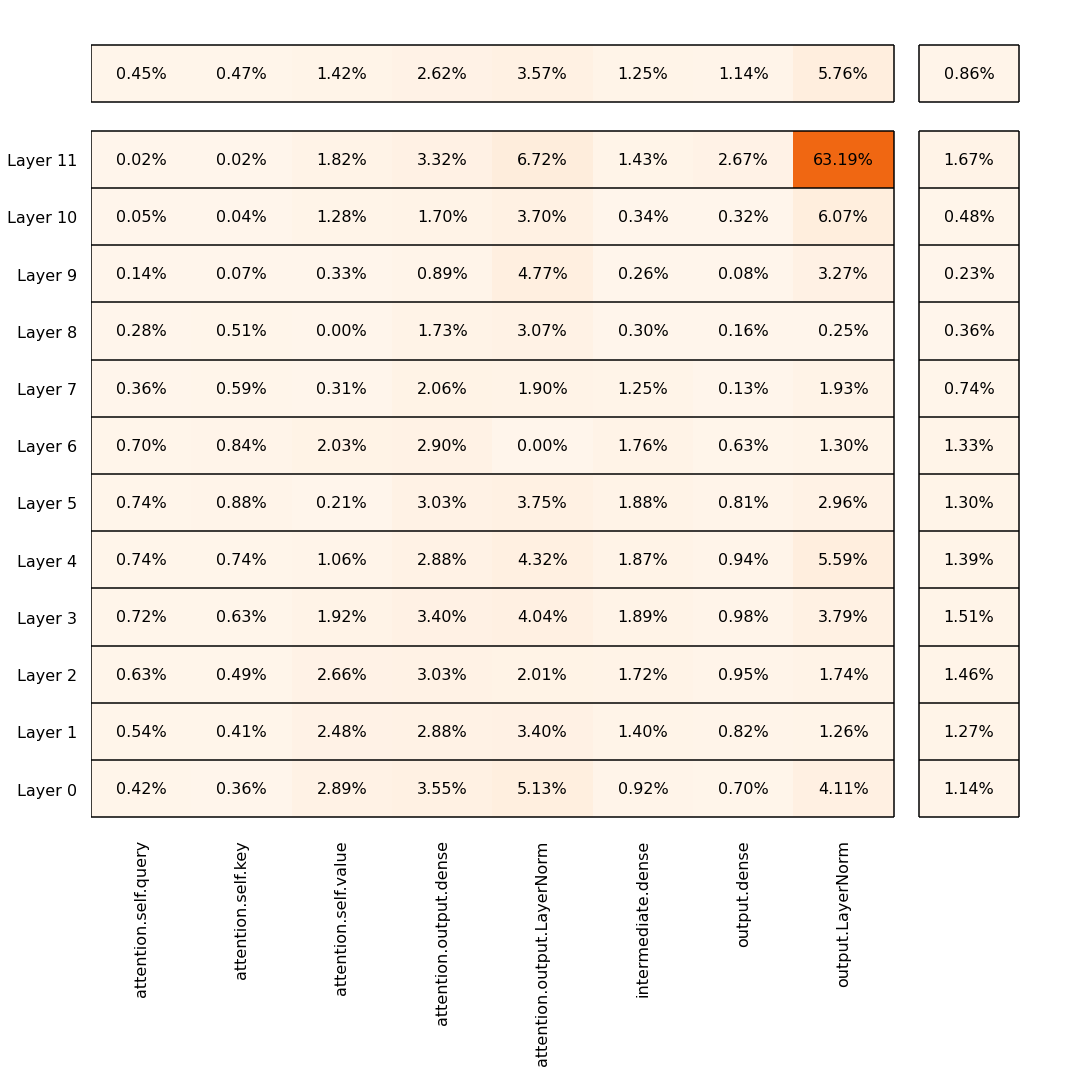

In [18]:
title_fontsize = 16
text_fontsize = 16
title = f"Density per module (transformer layers) - {model_cat} - {prot_attr}"
filename = f"density_per_module_transformer_layers_{model_cat.lower()}_{prot_attr}.png"

plt.figure(figsize=(15,15))
start = 0
for m_name in module_names:
    averages, error_margins = zip(*[l[m_name] for l in layer_list])
    m_average, m_error_margin = [ar_to_scalar(ar) for ar in module_dict[m_name]]
    color = [cmap(color_fn(a)) for a in averages]
    color.append("w")
    color.append(cmap(color_fn(m_average)))
    plt.barh(y_coords_adj, width, height=height, left=start, color=color)
    for y, a, e in zip(y_coords, averages, error_margins):
        a, e = ar_to_scalar(a), ar_to_scalar(e)
        if check_zero_fn(a,e):
            t = text_format.format(*text_fn(np.array([a, e])))
            plt.text(start+width/2, y, t, ha='center', va='center', color="k", fontsize=text_fontsize)
    if check_zero_fn(m_average, m_error_margin):
        t = text_format.format(*text_fn(np.array([m_average, m_error_margin])))
        plt.text(start+width/2, y_coords_adj[-1], t, ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

start += spacing

averages, error_margins = zip(*list(layer_dict.values())[1:])
overall_a, overall_e = overall_sparsity
color = [cmap(color_fn(a)) for a in averages]
color.append("w")
color.append(cmap(color_fn(overall_sparsity[0])))
plt.barh(y_coords_adj, width, height=height, left=start, color=color)
for y, a, e in zip(y_coords, averages, error_margins):
    a, e = ar_to_scalar(a), ar_to_scalar(e)
    if check_zero_fn(a,e):
        t = text_format.format(*text_fn(np.array([a, e])))
        plt.text(start+width/2, y, t, ha='center', va='center', color="k", fontsize=text_fontsize)
if check_zero_fn(overall_a,overall_e):
    t = text_format.format(*overall_sparsity)
    plt.text(start+width/2, y_coords_adj[-1], t, ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions:#[:-2]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0, y_coords[-1]+height/2, colors="black")
for x in vline_positions:#[:2]:
    plt.vlines(x, y_coords_adj[-1]-height/2, y_coords_adj[-1]+height/2, colors="black")

plt.xticks(np.arange(width*n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)
# plt.title(title, fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-20)
plt.tick_params(axis="y", left=False, pad=10)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()

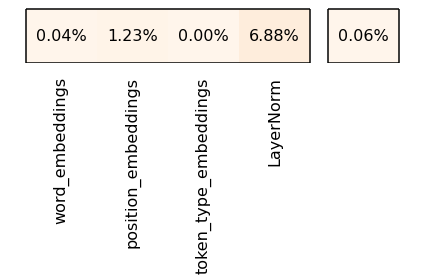

In [19]:
title = f"Density per module (embeddings) - {model_cat} - {prot_attr}"
filename = f"density_per_module_embeddings_{model_cat.lower()}_{prot_attr}.png"

assert n_modules >= emb_n_modules, "'x_coords_adj' is created based on n_modules and assumes emb_n_modules <= n_modules"

y_pos = -9
averages, error_margins= zip(*emb_dict.values())
l_average, l_error_margin = np.concatenate(layer_dict[0])
color = [cmap(color_fn(a)) for a in averages] + ["w", cmap(color_fn(l_average))]
plt.bar(x_coords_adj[-(emb_n_modules+2):], height=height, width=[width] * emb_n_modules + [spacing, width], bottom=y_pos, color=color)
for x, a, e in zip(x_coords[-emb_n_modules:], averages, error_margins):
    a, e = ar_to_scalar(a), ar_to_scalar(e)
    if check_zero_fn(a,e):
        t = text_format.format(*text_fn(np.array([a, e])))
        plt.text(x, y_pos + height/2, t, ha='center', va='center', color="k", fontsize=text_fontsize)
if check_zero_fn(l_average, l_error_margin):
    t = text_format.format(*text_fn(np.array([l_average, l_error_margin])))
    plt.text(x_coords_adj[-1], y_pos + height/2, t, ha='center', va='center', color="k", fontsize=text_fontsize)

x_coords_lines = [x_coords[-emb_n_modules]-width/2, [x_coords[-1]+width/2], x_coords_adj[-1]-width/2, x_coords_adj[-1]+width/2]
y_coords_lines = [y_pos, y_pos+height]
for y in y_coords_lines:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, y_coords_lines[0], y_coords_lines[1], colors="black")

plt.xticks(x_coords[-emb_n_modules:], labels=emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([height/2], labels=["embedding layer"], fontsize=text_fontsize)
# plt.title(title, fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=10)
plt.tick_params(axis="y", left=False, pad=-10)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()